In [106]:
import os

# if you want to use the GPU
# device = 'gpu'
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=' + device + ',floatX=float32'

import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np

from PIL import Image # Pillow module
#from theano import config
from sklearn.metrics import accuracy_score

# import keras
# from keras.models import Sequential
# from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
# from keras.layers.normalization import BatchNormalization

from tensorflow import keras
from keras.utils import np_utils

np.random.seed(1) # we initialize a random seed here to make the experiments repeatable with same results

## Load the Images from Training Set

# CIFAR Dataset

The dataset contains 50.000 datapoints of images classified into 10 classes:
- airplane
- automobile
- bird 	
- cat 
- deer 
- dog 
- frog 	
- horse 
- ship 
- truck

The images are 32 x 32 pixels in size and consists of 3 channels (rgb). Each class consists of 5000 images.

The source contains the files data_batch_1, data_batch_2, data_batch_3, data_batch_4, data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle. Here is a python routine which will open such a file and return a dictionary: 

In [107]:
def unpickle(file) -> dict:
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [108]:
path = 'Data\CIFAR'
files = glob.glob(os.path.join(path, '*_*'))
print("Found " + str(len(files)) + " files")

Found 5 files


## Make 1 big dictionary of training data

In [109]:
data = {b'labels': [], b'data': np.empty([0,3072], dtype=np.uint8) , b'filenames': [] }

for filename in files:
    print("Unpickling " + filename)
    newData = unpickle(filename)
    data[b'labels'].extend(newData[b'labels'])
    data[b'data'] = np.append(data[b'data'], newData[b'data'], axis=0)
    data[b'filenames'].extend(newData[b'filenames'])
    
print("# Classifications: " + str(len(data[b'labels'])))
print("# Images: " + str(len(data[b'data'])))
print("# Filenames: " + str(len(data[b'filenames'])))

print("Shape of the image data-array: " + str(data[b'data'].shape))

print(str(data[b'data']))


Unpickling Data\CIFAR\data_batch_3
Unpickling Data\CIFAR\data_batch_4
Unpickling Data\CIFAR\data_batch_5
Unpickling Data\CIFAR\data_batch_1
Unpickling Data\CIFAR\data_batch_2
# Classifications: 50000
# Images: 50000
# Filenames: 50000
Shape of the image data-array: (50000, 3072)
[[ 26  17  13 ...  27  26  27]
 [ 94 101  95 ... 182 184 155]
 [183 158 166 ... 250 250 250]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]


The resulting dictionary for one file most importantly contains

- **data:** a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 
- **labels:** a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

Looking at the first image. It is gorgeous.

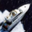

In [110]:
red = np.asarray(np.split(data[b'data'][0][0:1024], indices_or_sections=32))
green = np.asarray(np.split(data[b'data'][0][1024:2048], indices_or_sections=32))
blue = np.asarray(np.split(data[b'data'][0][2048:3072], indices_or_sections=32))
redImage = Image.fromarray(red)
greenImage = Image.fromarray(green)
blueImage = Image.fromarray(blue)
Image.merge('RGB', (redImage, greenImage, blueImage))


## What is the ground truth?

The gound truth can be found in the ditctionary-item "labels". There are 50.000 classifications (as many as images) as numbers from 0 to 9.

In [111]:
# look at the first 25 classes
data[b'labels'][0:25]

[8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2, 5, 6, 6, 0, 9]

In [112]:
classes_count = len(set(data[b'labels']))
print("# Classes: " + str(classes_count))

# Classes: 10


In [43]:
print("Groundtruth Statistics:")

for v in set(data[b'labels']):
    print("Class " + str(v) + ": " + str(data[b'labels'].count(v)))

Groundtruth Statistics:
Class 0: 5000
Class 1: 5000
Class 2: 5000
Class 3: 5000
Class 4: 5000
Class 5: 5000
Class 6: 5000
Class 7: 5000
Class 8: 5000
Class 9: 5000


In [52]:
class_categories = np_utils.to_categorical(data[b'labels'])
print(class_categories)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Standardization

<b>Always standardize</b> the data before feeding it into the Neural Network!

Here we use <b>Zero-mean Unit-variance standardization</b> which means we deduct the mean and divide by the standard deviation.

(Note: Here, we do this "flat", i.e. one mean and std.dev. for the whole image is computed over all pixels (not per pixel); in RGB images, standardization can be done e.g. for each colour channel individually; in other/non-image data sets, attribute-wise standardization should be applied).

In [45]:
print("Image values statistics:")
print("min pixel value: " + str(data[b'data'].min()))
print("max pixel value: " + str(data[b'data'].max()))

mean = data[b'data'].mean()
stddev = data[b'data'].std()

print("mean pixel value: " + str(mean))
print("standard deviation: " + str(stddev))

standardized_images = (data[b'data'] - mean) / stddev
print("Standardized image's mean: " + str(standardized_images.mean()))
print("Standardized image's standard deviation: " + str(standardized_images.std()))

print("Standardized image's min: " + str(standardized_images.min()))
print("Standardized image's max: " + str(standardized_images.max()))

Image values statistics:
min pixel value: 0
max pixel value: 255
mean pixel value: 120.70756512369792
standard deviation: 64.15007589112118
Standardized image's mean: -2.7083520611389153e-17
Standardized image's standard deviation: 0.9999999999999994
Standardized image's min: -1.881643372153901
Standardized image's max: 2.093410381995964


In [46]:
standardized_images

array([[-1.47634377, -1.61663979, -1.67899357, ..., -1.46075533,
        -1.47634377, -1.46075533],
       [-0.41632944, -0.30721032, -0.40074099, ...,  0.95545382,
         0.98663071,  0.53456577],
       [ 0.97104226,  0.58133111,  0.70603868, ...,  2.01546815,
         2.01546815,  2.01546815],
       ...,
       [ 0.09808928,  0.28515064,  0.53456577, ...,  1.18928051,
         1.11133828,  1.09574983],
       [ 1.08016139,  1.23604585,  1.36075342, ...,  0.65927334,
         0.95545382,  1.11133828],
       [ 0.87751159,  0.83074625,  0.95545382, ..., -0.02661829,
         0.09808928,  0.2383853 ]])

# Creating NN Models in Keras

## 1) Fully Connected NN

For a fully connected neural network, the x and y axis of an image do not play a role at all. All pixels are considered as a completely individual input to the neural network. Therefore the 2D image arrays have to be flattened to a vector.

In [47]:
# find out input shape for NN, which is just a long vector (40x100 = 4000)
input_shape = standardized_images.shape[1]
print("Input shape for NN: " + str(input_shape))

Input shape for NN: 3072


### Creating a Model

In Keras, one can choose between a Sequential model and a Graph model. Sequential models are the standard case. Graph models are for parallel networks and use the functional API.

Here we create a sequential model with 2 fully connected (a.k.a. 'dense') layers containing 256 units each.

The output unit is a Single sigmoid unit which can predict values between 0 and 1.

In [66]:
# simple Fully-connected network

model = keras.models.Sequential()

model.add(keras.layers.Dense(256, input_dim=input_shape))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(classes_count, activation='softmax'))


In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               786688    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________


### Defining Loss Function and Optimizer Strategy: Gradient Descent

### Training the model on the input dataset

In [157]:
# Defining the parameters globally for all subsequent models
loss = 'categorical_crossentropy'
optimizer = 'sgd'
metrics=['categorical_accuracy']
batch_size=32
epochs=15

In [69]:
# Compiling the model
# This creates the whole model structure in memory. 
# If you use GPU computation, here GPU compatible structures and code is generated.
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = model.fit(standardized_images, class_categories, batch_size=batch_size, epochs=epochs) #, validation_data=validation_data) 

Epoch 1/15
1563/1563 [==============================] - 4s 2ms/step - loss: 1.6945 - categorical_accuracy: 0.4093
Epoch 2/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.4419 - categorical_accuracy: 0.4960
Epoch 3/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.3395 - categorical_accuracy: 0.5345
Epoch 4/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.2660 - categorical_accuracy: 0.5605
Epoch 5/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.2060 - categorical_accuracy: 0.5831
Epoch 6/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1530 - categorical_accuracy: 0.6017
Epoch 7/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.1061 - categorical_accuracy: 0.6160
Epoch 8/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.0613 - categorical_accuracy: 0.6334
Epoch 9/15
1563/1563 [==============================] - 4s 3ms/step - loss: 1.0211 - cat

In [78]:
# verify Accuracy on Train set
predictions = model.predict(standardized_images)
predicted_classes = np.argmax(predictions, axis=1)
print("Accuracy Score of model: " + str(accuracy_score(np.array(data[b'labels']), predicted_classes)))

1563/1563 [==============================] - 2s 1ms/step
Accuracy Score of model: 0.7534


### 100% Accuracy - perfect, no?

This is the accuracy on the training set. A (large, especially fully connected network with sufficient number of units) can easily learn the entire training set (especially a small one like here).

This very likely leads to <b>overfitting</b>. That's why we test on an independent test set.


# Testing with Test Data Set

The test dataset contains 10.000 images with their classifications (categories are the same as with the training set). They can be found in one file (test_batch). Each class consists of 1000 images.

In [82]:
test_path = 'Data\CIFAR\Info'
test_files = glob.glob(os.path.join(test_path, 'test_batch'))
print("Found " + str(len(test_files)) + " files")

Found 1 files


In [95]:
test_data = {b'labels': [], b'data': np.empty([0,3072], dtype=np.uint8) , b'filenames': [] }

for filename in test_files:
    print("Unpickling " + filename)
    newTestData = unpickle(filename)
    test_data[b'labels'].extend(newTestData[b'labels'])
    test_data[b'data'] = np.append(test_data[b'data'], newTestData[b'data'], axis=0)
    test_data[b'filenames'].extend(newTestData[b'filenames'])
    
print("# Classifications: " + str(len(test_data[b'labels'])))
print("# Images: " + str(len(test_data[b'data'])))
print("# Filenames: " + str(len(test_data[b'filenames'])))

print("Shape of the image data-array: " + str(test_data[b'data'].shape))

print("Groundtruth Statistics:")

for v in set(test_data[b'labels']):
    print("Class " + str(v) + ": " + str(test_data[b'labels'].count(v)))

Unpickling Data\CIFAR\Info\test_batch
# Classifications: 10000
# Images: 10000
# Filenames: 10000
Shape of the image data-array: (10000, 3072)
Groundtruth Statistics:
Class 0: 1000
Class 1: 1000
Class 2: 1000
Class 3: 1000
Class 4: 1000
Class 5: 1000
Class 6: 1000
Class 7: 1000
Class 8: 1000
Class 9: 1000


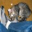

In [93]:
red = np.asarray(np.split(test_data[b'data'][0][0:1024], indices_or_sections=32))
green = np.asarray(np.split(test_data[b'data'][0][1024:2048], indices_or_sections=32))
blue = np.asarray(np.split(test_data[b'data'][0][2048:3072], indices_or_sections=32))
redImage = Image.fromarray(red)
greenImage = Image.fromarray(green)
blueImage = Image.fromarray(blue)
Image.merge('RGB', (redImage, greenImage, blueImage))

### Standardize Test Set

The test data has to be standardized <b>in the same way</b> as the training data for compatibility with the model! That means, we take the mean and standard deviation of the <i>training data</i> to transform also the test data.

In [94]:
print("Image values statistics:")
print("min pixel value: " + str(test_data[b'data'].min()))
print("max pixel value: " + str(test_data[b'data'].max()))

mean = test_data[b'data'].mean()
stddev = test_data[b'data'].std()

print("mean pixel value: " + str(mean))
print("standard deviation: " + str(stddev))

standardized_test_images = (test_data[b'data'] - mean) / stddev
print("Standardized image's mean: " + str(standardized_test_images.mean()))
print("Standardized image's standard deviation: " + str(standardized_test_images.std()))

print("Standardized image's min: " + str(standardized_test_images.min()))
print("Standardized image's max: " + str(standardized_test_images.max()))

Image values statistics:
min pixel value: 0
max pixel value: 255
mean pixel value: 121.52915475260417
standard deviation: 64.06097012299574
Standardized image's mean: -8.459899447643693e-17
Standardized image's standard deviation: 1.000000000000001
Standardized image's min: -1.8970857687492197
Standardized image's max: 2.083497096455682


### Make Predictions

In [97]:
# verify Accuracy on Test set
test_predictions = model.predict(standardized_test_images)
test_predicted_classes = np.argmax(test_predictions, axis=1)
print("Accuracy Score of model: " + str(accuracy_score(np.array(test_data[b'labels']), test_predicted_classes)))

313/313 [==============================] - 0s 1ms/step
Accuracy Score of model: 0.5272


Accuracy on the Test Set is considerably lower compared to the accuracy of the training set.

# Convolutional Neural Network

A Convolutional Neural Network (ConvNet or CNN) is a type of (deep) Neural Network that is well-suited for 2D axes data, such as images, as it is optimized for learning from spatial proximity. Its core elements are 2D filter kernels which essentially learn the weights of the Neural Network, and downscaling functions such as Max Pooling.

A CNN can have one or more Convolution layers, each of them having an arbitrary number of N filters (which define the depth of the CNN layer), following typically by a pooling step, which groups neighboring pixels together and thus reduces the image resolution by retaining only the maximum values of neighboring pixels.

### Input

As with the model above, our input to the CNN is the standardized version of the original image array. We already have three chanels for the colors available in the training and test sets.

We should deal with edge-pixels properly though.

In [103]:
standardized_images[0]

array([-1.47634377, -1.61663979, -1.67899357, ..., -1.46075533,
       -1.47634377, -1.46075533])

In [113]:
channels = 3
image_height = 32

train_images = standardized_images.reshape(standardized_images.shape[0], image_height, image_height, channels)
test_images = standardized_test_images.reshape(standardized_test_images.shape[0], image_height, image_height, channels)

In [116]:
print("Dimensions training dataset: " + str(standardized_images.shape))
print("Dimensions testing dataset: " + str(standardized_test_images.shape))

Dimensions training dataset: (50000, 3072)
Dimensions testing dataset: (10000, 3072)


In [117]:
print("Dimensions training dataset reshaped: " + str(train_images.shape))
print("Dimensions testing dataset reshaped: " + str(test_images.shape))

Dimensions training dataset reshaped: (50000, 32, 32, 3)
Dimensions testing dataset reshaped: (10000, 32, 32, 3)


In [126]:
# we store the new shape of the images in the 'input_shape' variable.
# take all dimensions except the 0th one (which is the number of images)
    
input_shape = train_images.shape[1:]  
input_shape

(32, 32, 3)

## Create the CNN model

I have taken the model design from this source: https://www.tensorflow.org/tutorials/images/cnn
It is designed to classify images from the CIFAR dataset as a tutorial.

In [144]:
def createMyModel():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(input_shape[0] * 2, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(input_shape[0] * 2, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(input_shape[0] * 2, (3, 3), activation='relu'))
    
    # To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64))
    # into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), 
    # while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one
    # or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.
    # (Source: https://www.tensorflow.org/tutorials/images/cnn)
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    
    return model

In [145]:
cnn_model = createMyModel()
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)            

Note: If you get OverflowError: Range exceeds valid bounds in the above box, check the correct Theano vs. Tensorflow ordering in the box before and your keras.json configuration file.

## Training the CNN

In [146]:
cnn_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

history = cnn_model.fit(train_images, class_categories, batch_size=batch_size, epochs=epochs)


Epoch 1/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7803 - categorical_accuracy: 0.3591
Epoch 2/15
1563/1563 [==============================] - 38s 25ms/step - loss: 1.4543 - categorical_accuracy: 0.4830
Epoch 3/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.3151 - categorical_accuracy: 0.5364
Epoch 4/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.2173 - categorical_accuracy: 0.5726
Epoch 5/15
1563/1563 [==============================] - 39s 25ms/step - loss: 1.1395 - categorical_accuracy: 0.6009
Epoch 6/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0766 - categorical_accuracy: 0.6238
Epoch 7/15
1563/1563 [==============================] - 41s 26ms/step - loss: 1.0263 - categorical_accuracy: 0.6416
Epoch 8/15
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9776 - categorical_accuracy: 0.6592
Epoch 9/15
1563/1563 [==============================] - 37s 24ms/step - 

A quick increase in accuracy and - after a few epochs - a stagnation in the gain of accuracy can be observed when training the model. However, as seen above, this accuracy must be considered with caution, since it probably will not perform as good on unseen (test) data.

### Verifying Accuracy on Test Set

In [149]:
# verify Accuracy on Train set
predictions = cnn_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
print("Accuracy Score of model: " + str(accuracy_score(np.array(test_data[b'labels']), predicted_classes)))

313/313 [==============================] - 3s 9ms/step
Accuracy Score of model: 0.6283


As suspected, the accuracy achieved with the test data is considerably lower than with the training data.

### Plotting the Training Curve

The `model.fit` function returns a history including the evolution of training and validation loss and accuracy. We can plot it to see a nice training curve.

In [151]:
training_history = history.history
training_history.keys()

dict_keys(['loss', 'categorical_accuracy'])

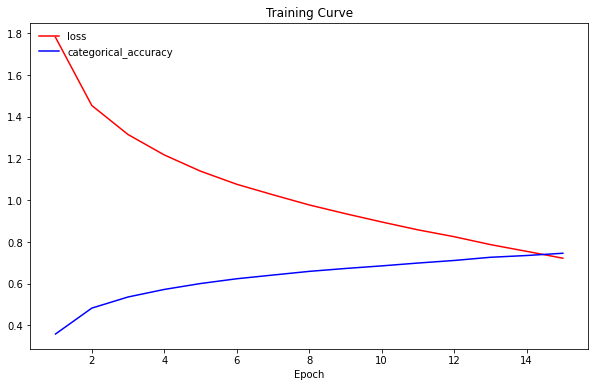

In [152]:
import matplotlib.pyplot as plt

colors = {'loss':'r', 'categorical_accuracy':'b'}
plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in training_history.keys():
    color = colors[measure]
    plt.plot(range(1,15+1), training_history[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


#### Conclusion
Even though the accuracy of the training set can't be achieved entirely, the accuracy with the test set is not terribly lower. It is significat however and shows that the accuracy achieved with the training set must not be trusted blindly.

# Data Augmentation

Increase the training set by adding more images: Rotate, shift, flip and scale the original images to generate additional examples that will help the Neural Network to generalize better.

In [153]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [154]:
# ImageDataGenerator needs the classes as Numpy array instead of normal list
np.array(test_data[b'labels'])

array([3, 8, 8, ..., 5, 1, 7])

In [155]:
np.random.seed(0) # enforce repeatable result

In [160]:
# recreate and recompile the model (otherwise we continue learning)
augmented_model = createMyModel()
augmented_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# fits the model on batches with real-time data augmentation:
history = augmented_model.fit(datagen.flow(train_images, class_categories, batch_size=batch_size), batch_size=batch_size, epochs=epochs) 

Epoch 1/15
1563/1563 [==============================] - 38s 24ms/step - loss: 2.0654 - categorical_accuracy: 0.2345
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.8870 - categorical_accuracy: 0.3035
Epoch 3/15
1563/1563 [==============================] - 40s 25ms/step - loss: 1.8222 - categorical_accuracy: 0.3276
Epoch 4/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7740 - categorical_accuracy: 0.3494
Epoch 5/15
1563/1563 [==============================] - 33s 21ms/step - loss: 1.7345 - categorical_accuracy: 0.3660
Epoch 6/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6900 - categorical_accuracy: 0.3848
Epoch 7/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6603 - categorical_accuracy: 0.3975
Epoch 8/15
1563/1563 [==============================] - 40s 26ms/step - loss: 1.6262 - categorical_accuracy: 0.4114
Epoch 9/15
1563/1563 [==============================] - 41s 26ms/step - 

### Verifying Accuracy on Test Set (with Data Augmentation)

In [161]:
# verify Accuracy on Train set
predictions = augmented_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
print("Accuracy Score of model: " + str(accuracy_score(np.array(test_data[b'labels']), predicted_classes)))

313/313 [==============================] - 4s 11ms/step
Accuracy Score of model: 0.4546


# Conclusion

In this instance, data augmentation did not achieve better accuracy values. This might be, because the images are too small for rotation and zoom to give any diversification in trainable images.

### Plotting the Training Curve with Data Augmentation 

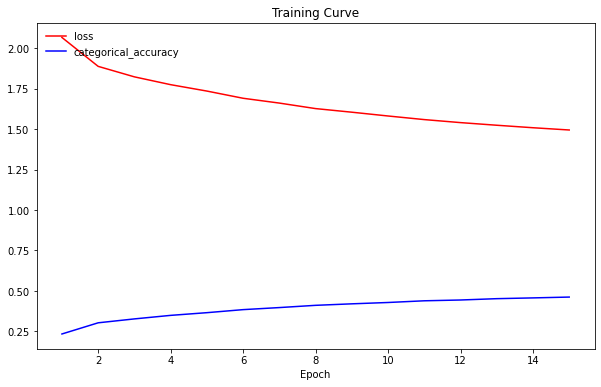

In [162]:
hist = history.history

plt.figure(figsize=(10,6))
plt.title("Training Curve") 
plt.xlabel("Epoch")

for measure in hist.keys():
    color = colors[measure]
    plt.plot(range(1,epochs+1), hist[measure], color + '-', label=measure)  # use last 2 values to draw line

plt.legend(loc='upper left', scatterpoints = 1, frameon=False)


The training accuracy does not increase as fast and stops considerably lower than with the un-augmented data.

# Conclusion:

The CNN performs better than the fully connected NN. However, augmenting the training data does not imporove accuracy performance. The CIFAR images seem to be resistant to augmentation because of their small size and therefore low reolution. Training the models is rather fast. The CNN is considerably slower, but with only 50000 images, it is still reasonable.